In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from glob import glob
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

import timm


In [2]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

In [ ]:
ckpt_fn = "models/orig_20220627-235055-seresnext50_32x4d-224/last.pth.tar"
im_path = "data/orig_o"

fl_dict = {}
for idx, fl in enumerate(glob(f"{im_path}/*")):
    bn = os.path.basename(fl)
    fl_dict[bn] = idx

In [3]:
ckpt_fn = "models/planted_20220627-235814-seresnext50_32x4d-224/last.pth.tar"
im_path = "data/pl_o"
out_path = "pl_pl"

fl_dict = {}
for idx, fl in enumerate(glob(f"{im_path}/*")):
    bn = os.path.basename(fl)
    fl_dict[bn] = idx

In [4]:
model = timm.create_model(
        'seresnext50_32x4d',
        num_classes=300,
        in_chans=3,
        pretrained=True,
        checkpoint_path=ckpt_fn)

target_layers = model.layer4

images = glob(f"{im_path}/**/*.*", recursive=True)

In [ ]:
cam = GradCAM(model=model, target_layers=target_layers)
eig = EigenCAM(model=model, target_layers=target_layers)
def process(im_fn, fl_dict):
    bn = os.path.basename(im_fn)
    cat = fl_dict[im_fn.split("/")[-2]]
    
    img = Image.open(im_fn)
    img_t = get_input_tensors(img)
    test_img = np.array(img.resize((224, 224)), dtype='float32')
    test_img /= 255

    targets = [ClassifierOutputTarget(cat)]

    grayscale_cam = cam(input_tensor=img_t, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(test_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    try:
        plt.savefig(f"outs/{out_path}/gradcam/{bn}")
    except FileNotFoundError:
        os.makedirs(f"outs/{out_path}/gradcam/")
    plt.clf()
    
    grayscale_eig = eig(input_tensor=img_t, targets=targets)
    grayscale_eig = grayscale_eig[0, :]

    visualization = show_cam_on_image(test_img, grayscale_eig, use_rgb=True)
    plt.imshow(visualization)
    try:
        plt.savefig(f"outs/{out_path}/eigencam/{bn}")
    except FileNotFoundError:
        os.makedirs(f"outs/{out_path}/eigencam/")
    plt.clf()
    
Parallel(n_jobs=8)(delayed(process)(im_fn, fl_dict) for im_fn in tqdm(images, total=len(list(images))))

  0%|          | 0/7859 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 64/64 [05:28<00:00,  5.13s/it]

 48%|████████████████████▊                      | 31/64 [02:42<02:55,  5.31s/it]


100%|███████████████████████████████████████████| 64/64 [05:43<00:00,  5.37s/it]

 98%|██████████████████████████████████████████▎| 63/64 [05:39<00:05,  5.38s/it]


100%|███████████████████████████████████████████| 64/64 [05:45<00:00,  5.39s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'outs/o_o/ablationcam/04491__051-1.jpg'

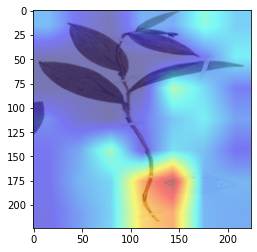

In [5]:
abl = AblationCAM(model=model, target_layers=target_layers)
for im_fn in tqdm(images, total=len(list(images))):
    bn = os.path.basename(im_fn)
    cat = fl_dict[im_fn.split("/")[-2]]
    
    img = Image.open(im_fn)
    img_t = get_input_tensors(img)
    test_img = np.array(img.resize((224, 224)), dtype='float32')
    test_img /= 255

    targets = [ClassifierOutputTarget(cat)]
    
    grayscale_abl = abl(input_tensor=img_t, targets=targets)
    grayscale_abl = grayscale_abl[0, :]

    visualization = show_cam_on_image(test_img, grayscale_abl, use_rgb=True)
    plt.imshow(visualization)
    try:
        plt.savefig(f"outs/{out_path}/ablationcam/{bn}")
    except FileNotFoundError:
        os.makedirs(f"outs/{out_path}/ablationcam/")
    plt.clf()